**Importing dependencies**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, chi2_contingency
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import shap
import joblib


**Load and inspect the dataset**

In [3]:

data = pd.read_csv("diabetes.csv")

data.head()


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


**Exploratory Data analysis**

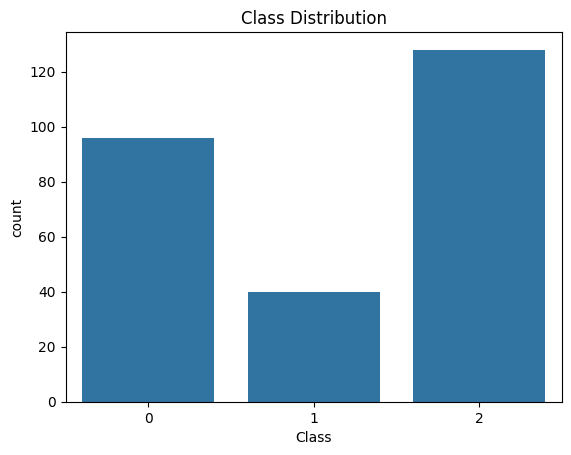

Gender                                                 AGE             \
       count      mean       std  min  25%  50%  75%  max  count       mean   
Class                                                                         
0       96.0  0.395833  0.491596  0.0  0.0  0.0  1.0  1.0   96.0  44.270833   
1       40.0  0.675000  0.474342  0.0  0.0  1.0  1.0  1.0   40.0  43.400000   
2      128.0  0.617188  0.487983  0.0  0.0  1.0  1.0  1.0  128.0  55.375000   

       ...   VLDL          BMI                                            \
       ...    75%   max  count       mean       std   min      25%   50%   
Class  ...                                                                 
0      ...  1.000  14.5   96.0  22.350000  1.429022  19.0  21.0000  22.0   
1      ...  1.325   2.4   40.0  24.112500  2.964507  19.0  23.0000  24.0   
2      ...  1.525  31.8  128.0  30.620234  4.196717  20.0  27.8325  30.0   

                    
        75%    max  
Class               
0      24.0  24.60  
1      25.0  32.00  
2      33.0  43.25  

[3 rows x 88 columns]

In [7]:
# Class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

# Descriptive stats by class
display(data.groupby('Class').describe())


In [32]:
# Descriptive statistics by class
print(data.groupby('Class').describe())

      Gender                                                 AGE             \
       count      mean       std  min  25%  50%  75%  max  count       mean   
Class                                                                         
0.0     96.0  0.395833  0.491596  0.0  0.0  0.0  1.0  1.0   96.0  44.270833   
1.0     40.0  0.675000  0.474342  0.0  0.0  1.0  1.0  1.0   40.0  43.400000   
2.0    128.0  0.617188  0.487983  0.0  0.0  1.0  1.0  1.0  128.0  55.375000   

       ...      Age_BMI              HbA1c_Chol                               \
       ...          75%          max      count       mean        std    min   
Class  ...                                                                     
0.0    ...  1127.250000  1848.000000       96.0  19.399167   7.196628   0.00   
1.0    ...  1228.750000  1512.000000       40.0  26.530500   6.350947  12.39   
2.0    ...  1933.944994  2516.017725      128.0  43.881578  17.988757  15.80   

                                       
    

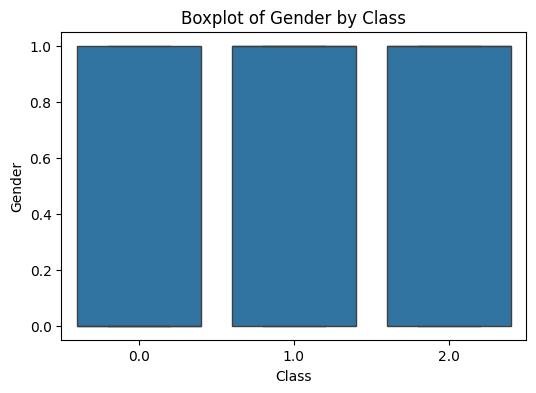

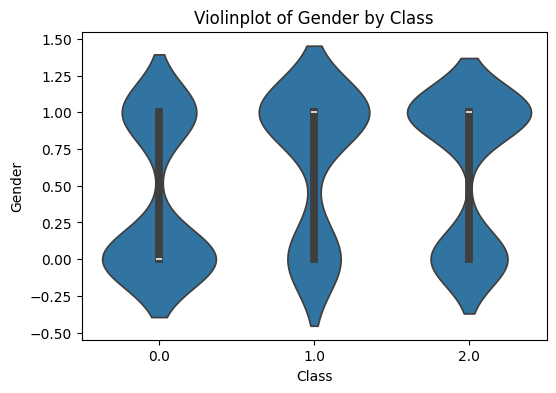

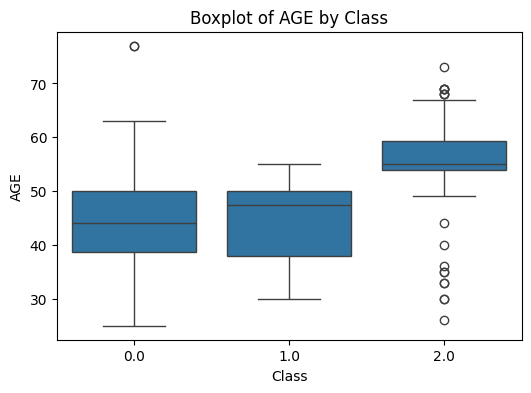

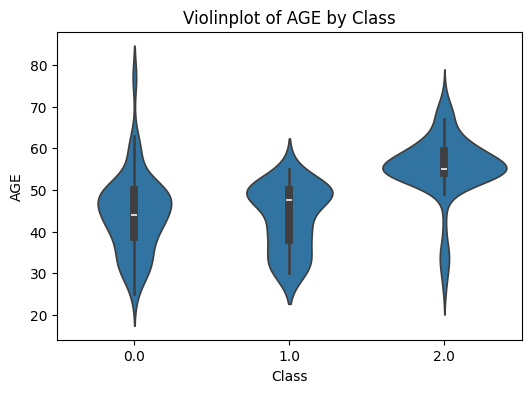

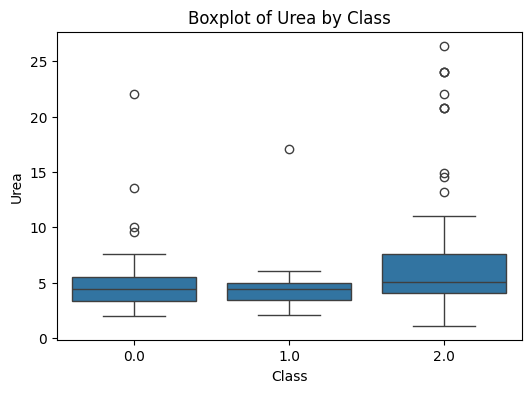

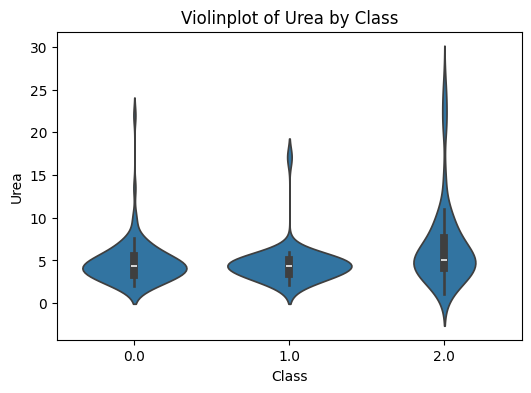

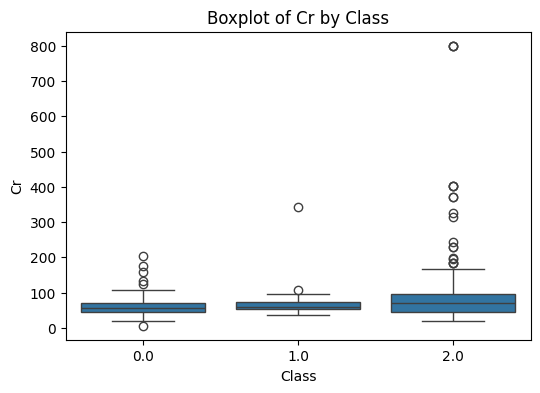

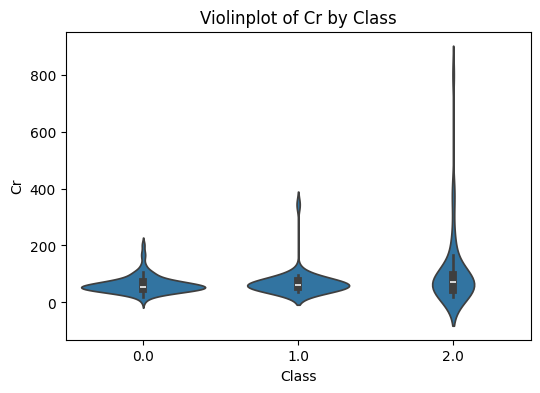

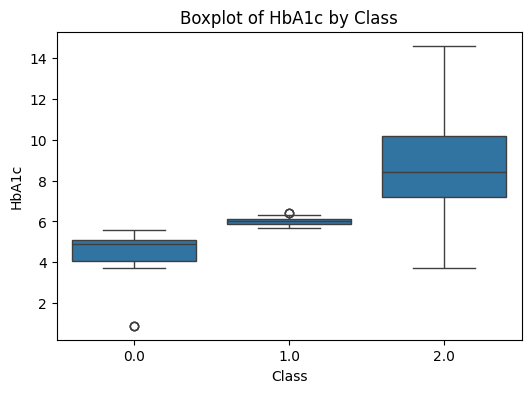

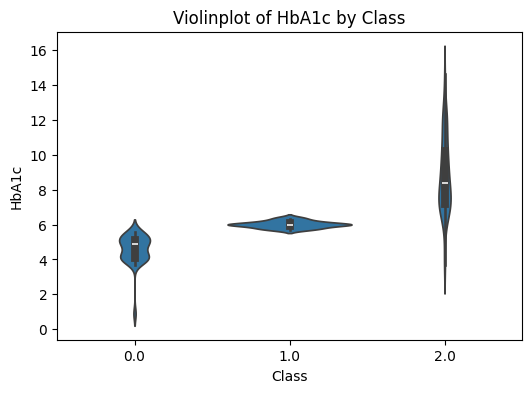

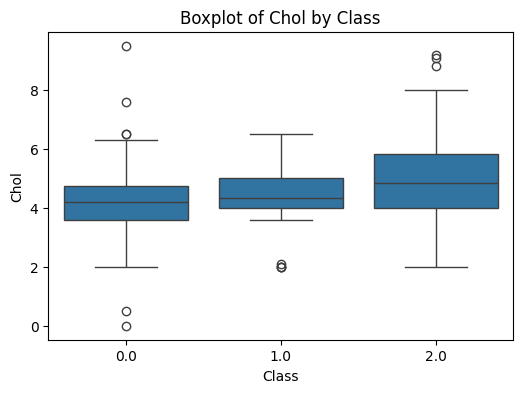

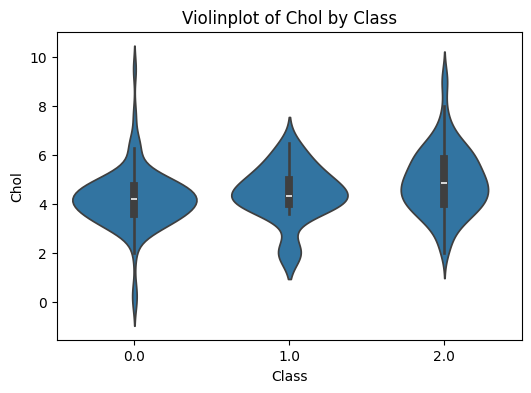

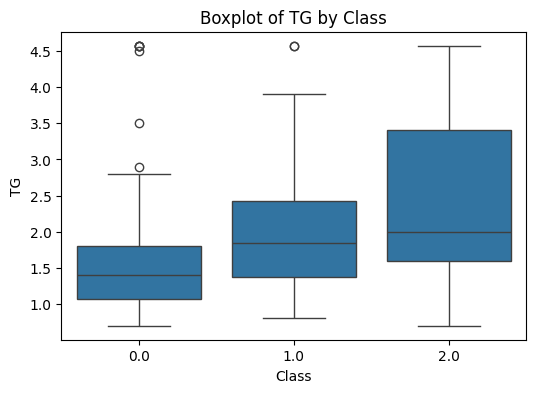

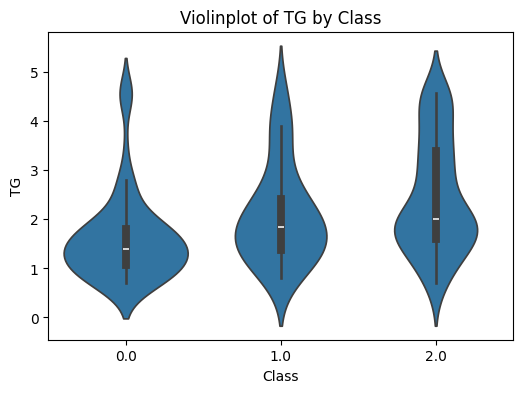

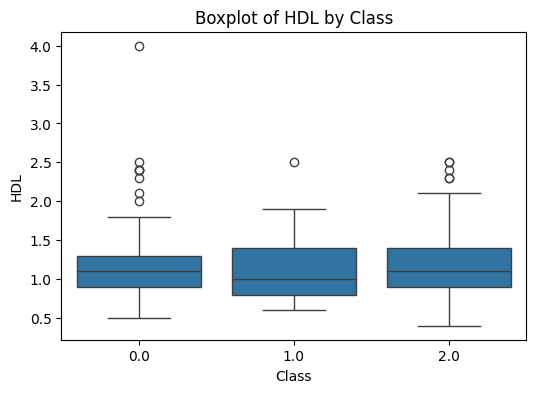

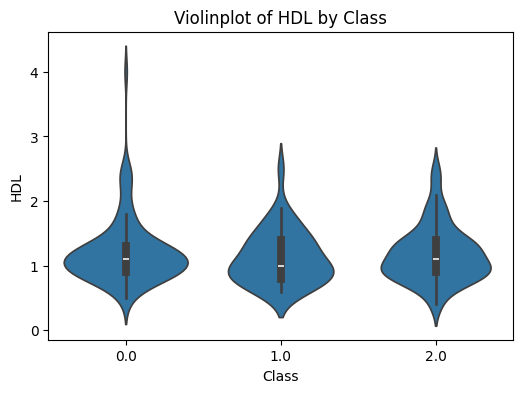

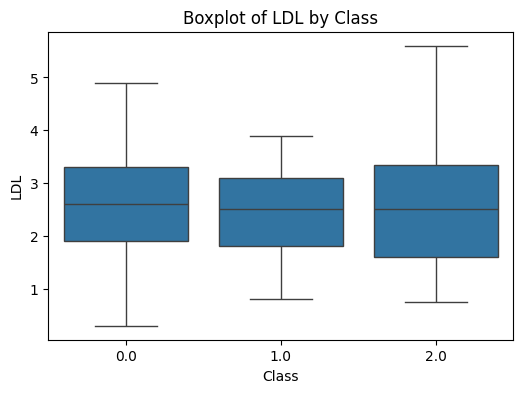

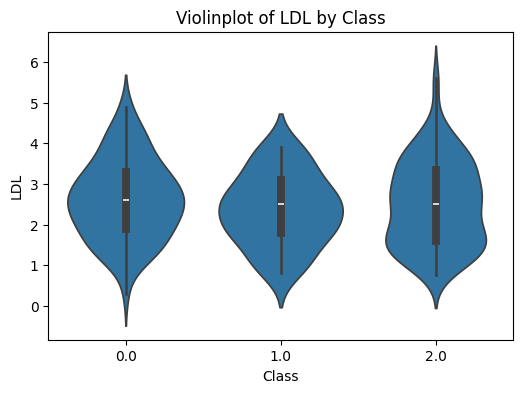

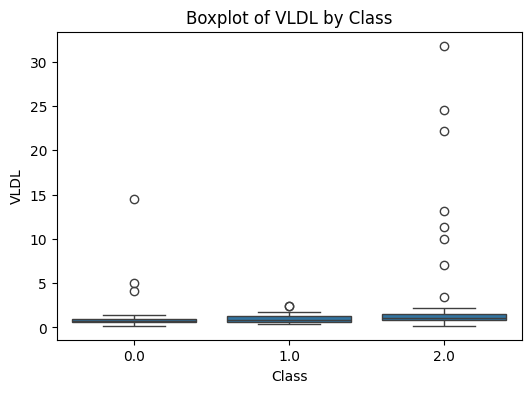

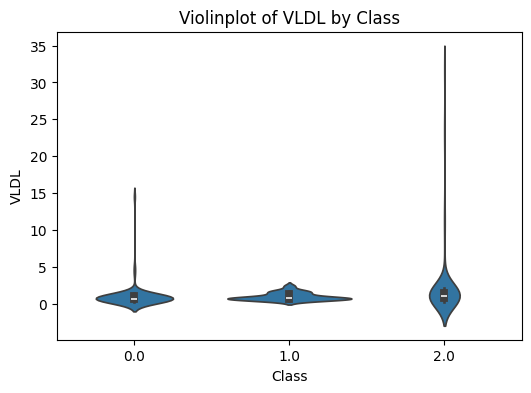

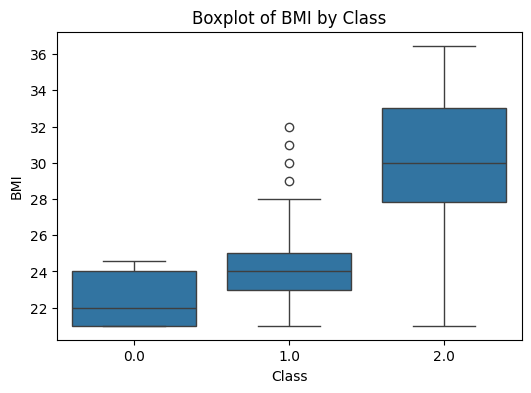

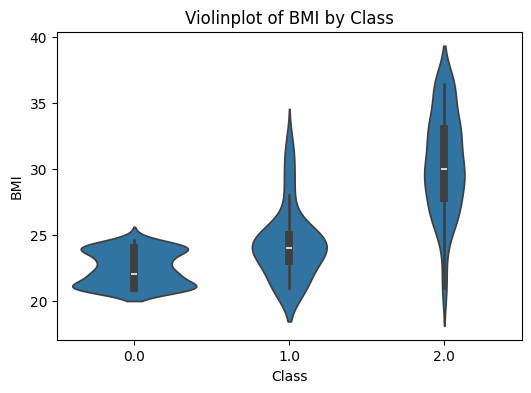

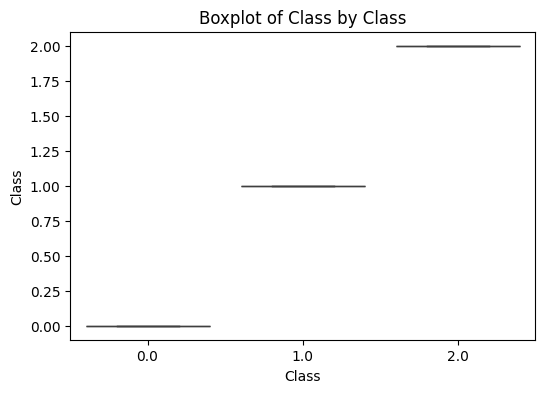

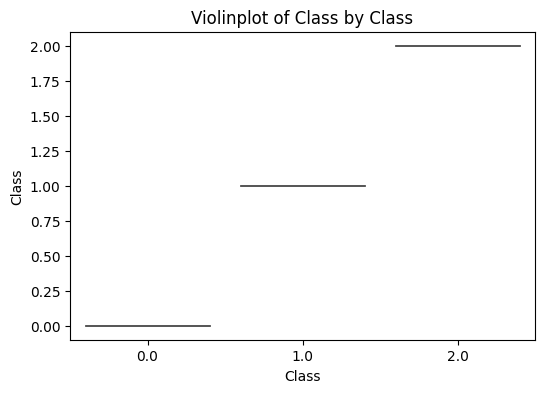

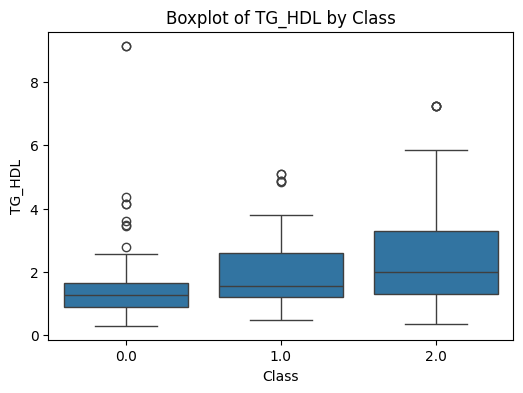

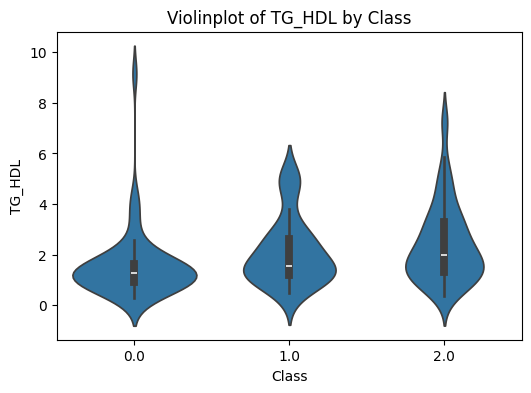

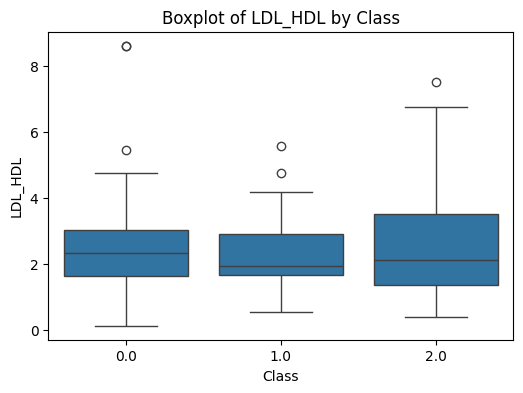

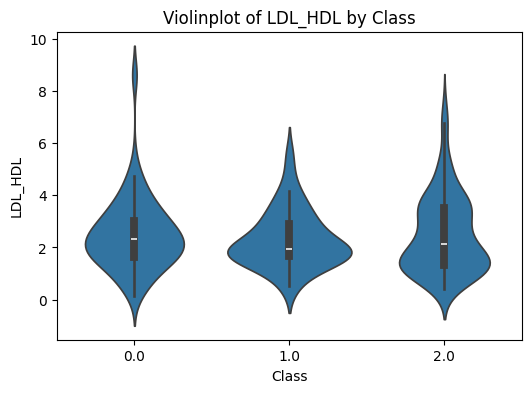

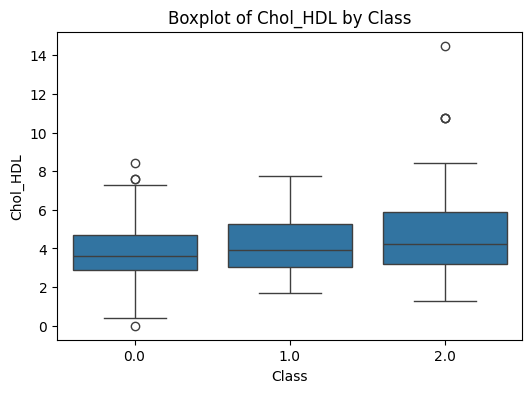

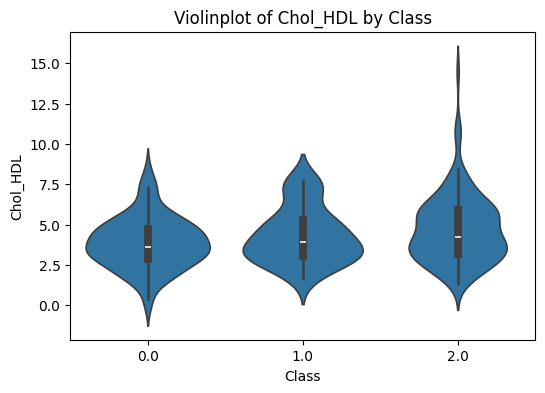

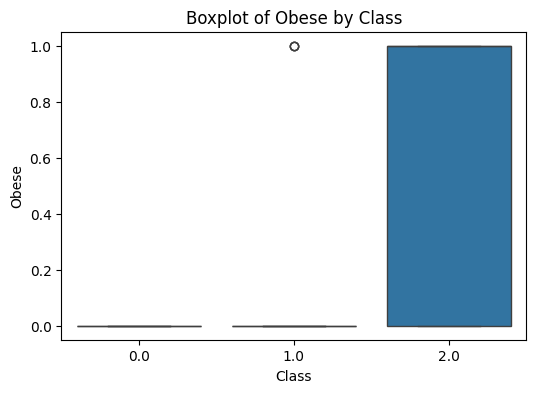

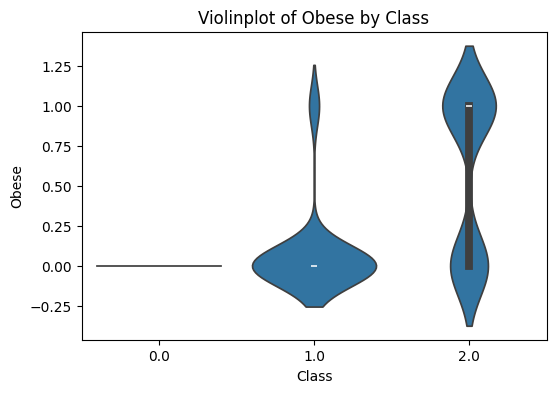

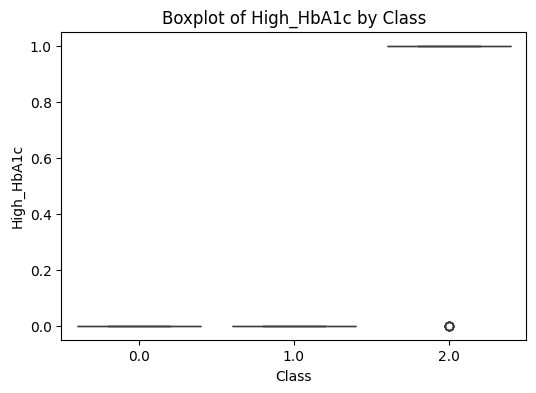

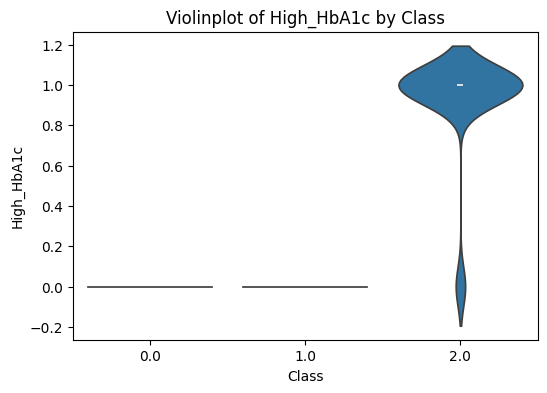

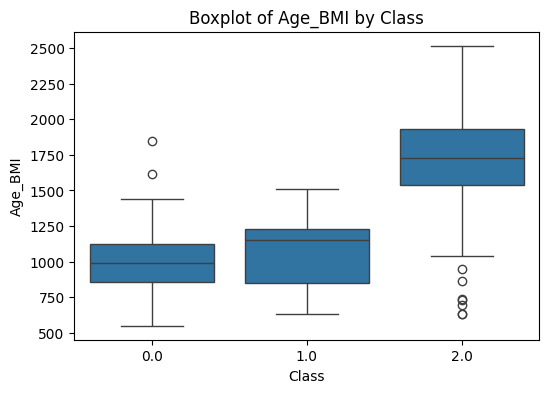

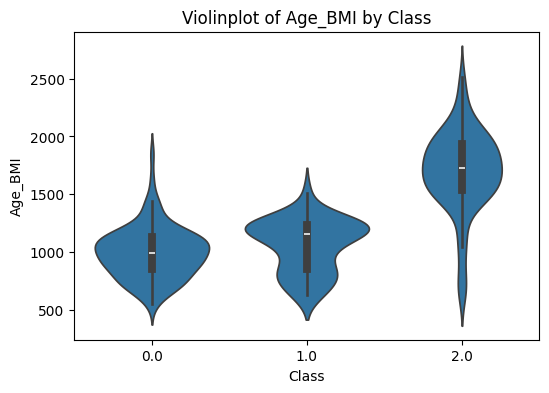

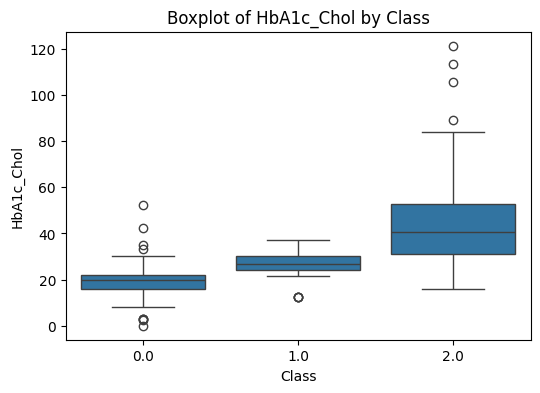

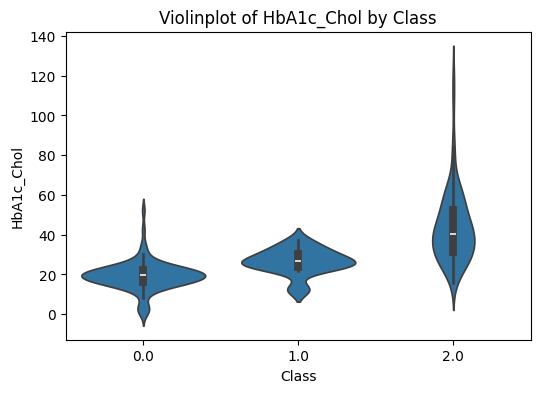

In [33]:
# Boxplots / violin plots for all numeric features
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
for feature in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Class', y=feature, data=data)
    plt.title(f"Boxplot of {feature} by Class")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.violinplot(x='Class', y=feature, data=data)
    plt.title(f"Violinplot of {feature} by Class")
    plt.show()

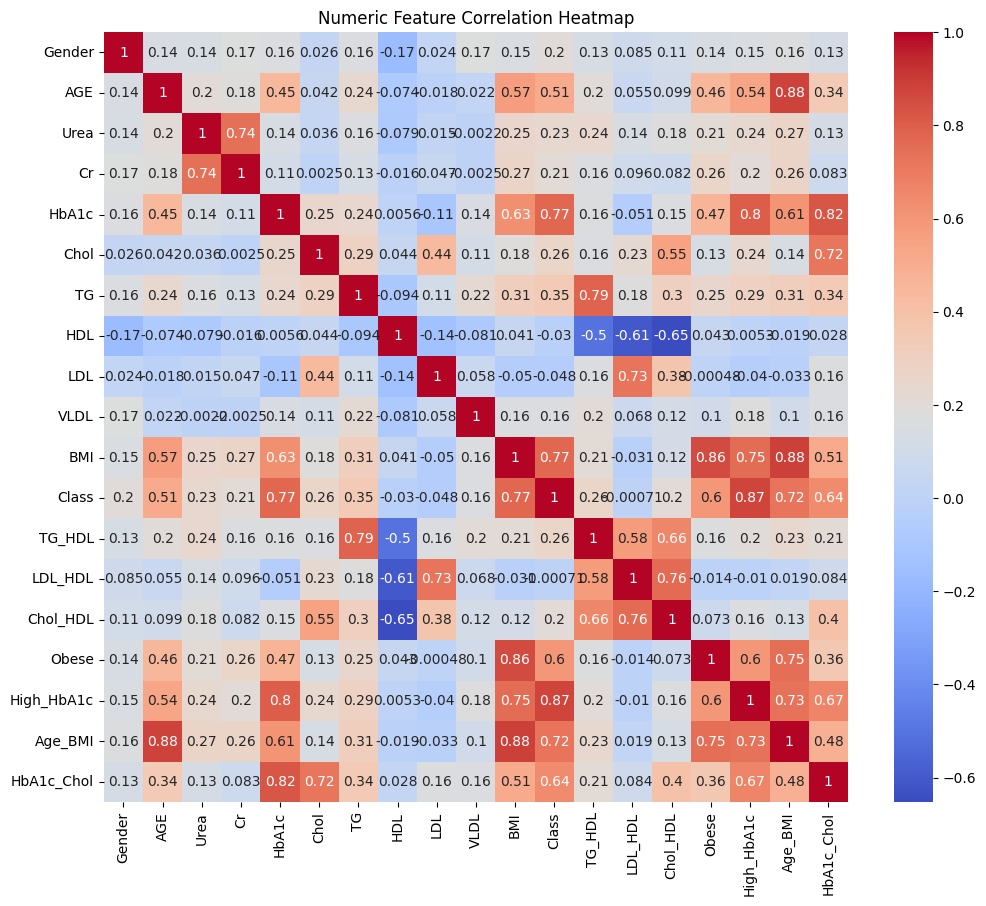

In [34]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

**Missing Data Analysis & Imputation**

In [36]:
from sklearn.impute import SimpleImputer

# Identify categorical columns
cat_cols = data.select_dtypes(include=['object','category']).columns.tolist()

if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    # Fit and transform
    cat_imputed = cat_imputer.fit_transform(data[cat_cols])

    # Convert back to DataFrame with original column names
    cat_imputed_df = pd.DataFrame(cat_imputed, columns=cat_cols, index=data.index)

    # Assign back to original dataframe
    data[cat_cols] = cat_imputed_df

print("✅ Categorical missing values imputed")


✅ Categorical missing values imputed


**Outlier Handling**

In [37]:
# Clip extreme values at 1st and 99th percentiles
for col in numeric_features:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)

print("✅ Outliers handled via clipping")


✅ Outliers handled via clipping


**Feature Engineering**

In [38]:
# Ratios
data['TG_HDL'] = data['TG'] / data['HDL']
data['LDL_HDL'] = data['LDL'] / data['HDL']
data['Chol_HDL'] = data['Chol'] / data['HDL']

# Binary flags
data['Obese'] = np.where(data['BMI'] >= 30, 1, 0)
data['High_HbA1c'] = np.where(data['HbA1c'] >= 6.5, 1, 0)

# Interaction terms
data['Age_BMI'] = data['AGE'] * data['BMI']
data['HbA1c_Chol'] = data['HbA1c'] * data['Chol']

print("✅ Feature engineering complete")


✅ Feature engineering complete


**Correlation Analysis**

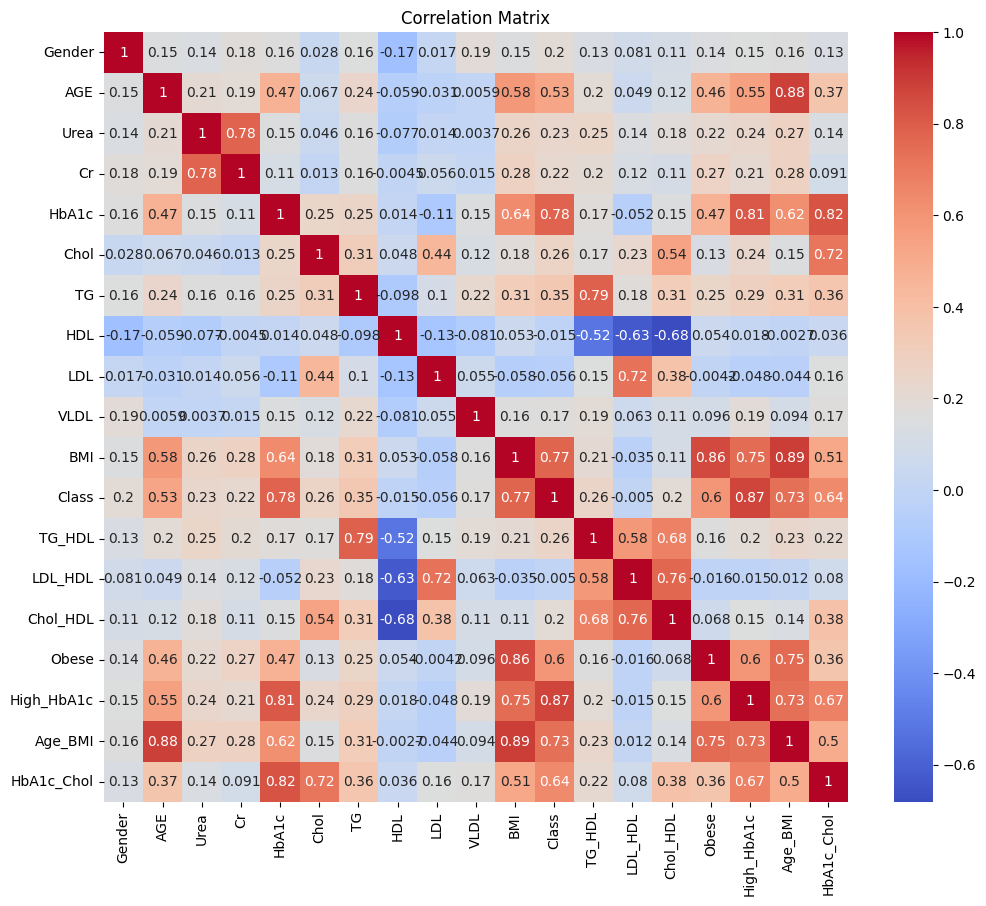

Highly correlated feature pairs (>0.9): []


In [39]:
corr_matrix = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Check multicollinearity: drop if correlation > 0.9 (optional)
high_corr = np.where(corr_matrix > 0.9)
high_corr = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr) if x != y and x < y]
print("Highly correlated feature pairs (>0.9):", high_corr)


**Feature Selecting**

In [41]:
# Select all relevant features (raw + engineered)
feature_cols = ['AGE','HbA1c','Chol','TG','BMI','HDL','LDL','VLDL','Urea','Cr',
                'TG_HDL','LDL_HDL','Chol_HDL','Obese','High_HbA1c','Age_BMI','HbA1c_Chol']

X = data[feature_cols]
y = data['Class']

**Train Test Split**

In [45]:
# ===========================================
# 9️⃣ Train-Test Split & Save Raw Test CSV
# ===========================================
from sklearn.model_selection import train_test_split

# Split raw features (first 11 columns are raw)
raw_features = ['AGE','HbA1c','Chol','TG','BMI','HDL','LDL','VLDL','Urea','Cr','BMI']  # adjust as per raw columns
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X[raw_features],
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# Save raw test CSV for Flask
X_test_export = X_test_raw.copy()
X_test_export['Class'] = y_test.values
X_test_export.to_csv('diabetes_test.csv', index=False)
print("✅ Raw test CSV saved for deployment")


✅ Raw test CSV saved for deployment


**Applying Feature Engineering to Training Data**


In [49]:
# ===========================================
# 10️⃣ Feature Engineering + Scaling (Fixed)
# ===========================================

from sklearn.preprocessing import StandardScaler

# Make a copy of raw training set
X_train = X_train_raw.copy()

# Ensure all required columns are Series
def get_series(df, col):
    # If selection returns DataFrame, squeeze to Series
    s = df[col]
    if isinstance(s, pd.DataFrame):
        return s.iloc[:,0]
    return s

AGE = get_series(X_train, 'AGE')
HbA1c = get_series(X_train, 'HbA1c')
Chol = get_series(X_train, 'Chol')
TG = get_series(X_train, 'TG')
BMI = get_series(X_train, 'BMI')
HDL = get_series(X_train, 'HDL')
LDL = get_series(X_train, 'LDL')

# -------------------------
# Feature Engineering
# -------------------------
X_train['TG_HDL'] = TG / HDL
X_train['LDL_HDL'] = LDL / HDL
X_train['Chol_HDL'] = Chol / HDL

X_train['Obese'] = (BMI >= 30).astype(int)
X_train['High_HbA1c'] = (HbA1c >= 6.5).astype(int)

X_train['Age_BMI'] = AGE * BMI
X_train['HbA1c_Chol'] = HbA1c * Chol

print("✅ Feature engineering completed")

# -------------------------
# Scaling
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("✅ Scaling completed. Training set ready for model training.")


✅ Feature engineering completed
✅ Scaling completed. Training set ready for model training.


**Model Training**


In [50]:
# ===========================================
# 11️⃣ Model Training with XGBoost
# ===========================================
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train on scaled training data
xgb_model.fit(X_train_scaled, y_train)

print("✅ XGBoost model trained")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:29:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost model trained


**Model Evaluation**

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      1.00      1.00         8
         2.0       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



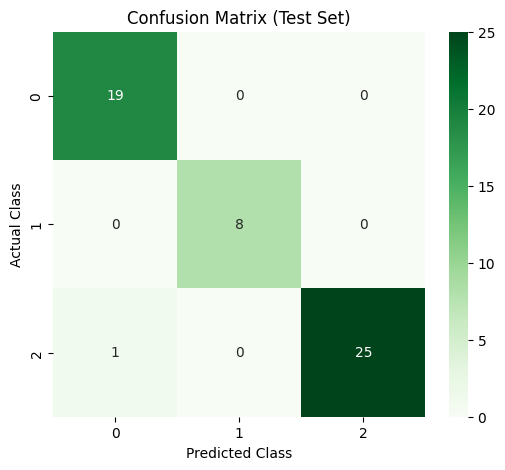

In [78]:
# Ensure test features match pipeline's training feature names
pipeline_features = pipeline.named_steps['scaler'].feature_names_in_
missing_cols = [col for col in pipeline_features if col not in X_test.columns]
extra_cols = [col for col in X_test.columns if col not in pipeline_features]

if missing_cols:
    raise ValueError(f"Missing columns in test set: {missing_cols}")
if extra_cols:
    print(f"Warning: Extra columns in test set will be ignored: {extra_cols}")

# Reorder columns to match pipeline
X_test_ordered = X_test[pipeline_features]

# Predict
y_pred_test = pipeline.predict(X_test_ordered)
y_prob_test = pipeline.predict_proba(X_test_ordered)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


In [77]:

# Prepare metrics dictionary
metrics = {
    "classification_report": classification_report(y_test, y_pred_test, output_dict=True),
    "confusion_matrix": cm_test.tolist(),
    "macro_f1": f1_score(y_test, y_pred_test, average='macro'),
    "weighted_f1": f1_score(y_test, y_pred_test, average='weighted')
}

# Save metrics to uploads folder for Flask
joblib.dump(metrics, 'model_metrics.pkl')

print("✅ Pipeline and metrics saved for deployment.")


✅ Pipeline and metrics saved for deployment.


**Saving the best model and Test set for flask application**

In [56]:
# ===========================================
# 🔹 Save XGBoost Pipeline for Flask
# ===========================================
import joblib
from sklearn.pipeline import Pipeline

# Pipeline: scaler + trained XGBoost model
pipeline = Pipeline([
    ('scaler', scaler),     # trained StandardScaler
    ('model', xgb_model)    # trained XGBoost model
])

# Fit pipeline on the training set (engineered features)
pipeline.fit(X_train, y_train)

model_path = 'diabetes_model.pkl'
joblib.dump(pipeline, model_path)

print(f"✅ Pipeline saved successfully at '{model_path}'")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:34:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Pipeline saved successfully at 'diabetes_model.pkl'
